In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

c:\Users\jako\Anaconda3\envs\jako_testar\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\jako\Anaconda3\envs\jako_testar\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\jako\Anaconda3\envs\jako_testar\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\jako\Anaconda3\envs\jako_testar\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Generating some fake data from 3 Gaussians  

In [2]:
men = np.random.normal(loc=180, scale=5, size=1000)
women = np.random.normal(loc=160, scale=5, size=1000)
children = np.random.normal(loc=130, scale=5, size=1000)

(array([  2.,  29.,  75., 147., 195., 236., 181.,  97.,  28.,  10.]),
 array([114.44494462, 117.46170274, 120.47846086, 123.49521899,
        126.51197711, 129.52873523, 132.54549335, 135.56225148,
        138.5790096 , 141.59576772, 144.61252584]),
 <BarContainer object of 10 artists>)

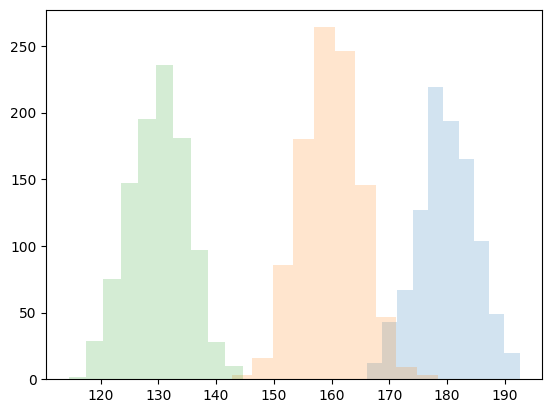

In [3]:
plt.hist(men, alpha=.2)
plt.hist(women, alpha=.2)
plt.hist(children, alpha=.2)

### Data generating process
<br>

$z \backsim N(\theta_i, \space\sum_i)$

$z | (V = i) \backsim N(\theta_i, \space\sum_i) \space , \space  \space i  \in {1, 2, 3}$

$V \backsim Multinom(\gamma_1, \gamma_2, \gamma_3)$ 

$men  |  z = 1 \backsim N(\mu_1, \sigma_1)$

$women  |  z = 2 \backsim N(\mu_2, \sigma_3)$

$children  |  z = 3 \backsim N(\mu_3, \sigma_3)$


<br>

 

In [4]:
z = []

for val in range(len(men)):
    
    flip = np.random.multinomial(1, [0.35, 0.45, 0.2], size=1)
    
    if flip[:, 0] > 0:
        z.append( np.random.choice(men, replace=False) )
    elif flip[:, 1]:
        z.append( np.random.choice(women, replace=False) )
        
    else:
        z.append( np.random.choice(children, replace=False) )

(array([  2.,  29.,  75., 147., 195., 236., 181.,  97.,  28.,  10.]),
 array([114.44494462, 117.46170274, 120.47846086, 123.49521899,
        126.51197711, 129.52873523, 132.54549335, 135.56225148,
        138.5790096 , 141.59576772, 144.61252584]),
 <BarContainer object of 10 artists>)

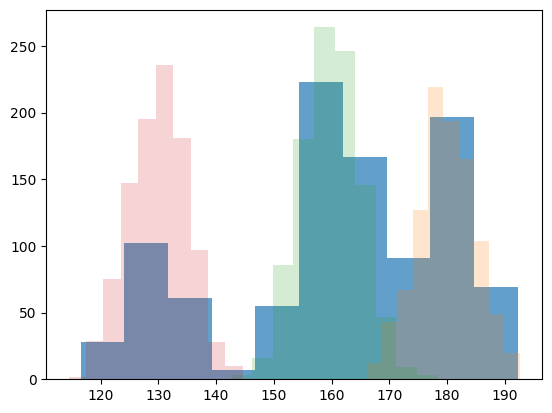

In [5]:
plt.hist(z, alpha=.7)
plt.hist(men, alpha=.2)
plt.hist(women, alpha=.2)
plt.hist(children, alpha=.2)

### Let us use a Gaussian Mixture Model from sklearn to see what we can get

In [6]:
z_gmm = np.array(z).reshape(-1, 1) # Vector form (matrix form for arrays)
model1 = GaussianMixture(n_components=3)
model1.fit(z_gmm)
print("Mu:", model1.means_)
print("Sigma:", np.sqrt(model1.covariances_))
print("Weights:", model1.weights_)

Mu: [[180.46002324]
 [129.46106328]
 [160.68156186]]
Sigma: [[[4.8767511 ]]

 [[5.00332661]]

 [[5.22953867]]]
Weights: [0.34265357 0.19783169 0.45951474]


### And now from scratch to see what we get with the EM-algorithm

In [8]:
# Normal PDF
def pdfnorm(mu, sd, x):
    return ((sd*np.sqrt(2*np.pi))**-1) * np.exp(-.5 * ((x - mu) / sd)**2)


# Use the mean of the mixture distribution of z and the standard deviation
k = 3 # for 3 groups

mu = np.random.normal(158, 10, size=k)

sigma = np.random.lognormal(2, size=k) # truncated variance

weights = np.ones(k) / k   # uniform weights to be updated later

responsibilities = np.zeros((len(z), k)) # Zero matrix to be filled later

# Updating steps until convergence
for i in range(500): 
    # E-step: responsibilities (posterior probabilities) computational part for each group
    for group in range(k):
        responsibilities[:, group] = weights[group] * pdfnorm(mu[group], sigma[group], z)  # Compute posterior probabilities
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=1) # Normalize the posterior
    
    # M-step: updating parameters for each group
    for group in range(k):
        weights[group] = responsibilities[:, group].mean()
        mu[group] = (responsibilities[:, group] * z).sum() / responsibilities[:, group].sum()
        sigma[group] = np.sqrt((responsibilities[:, group] * (z - mu[group])**2).sum() / responsibilities[:, group].sum())

In [9]:
print("Mu:", mu)
print("Sigma:", sigma)
print("Weights:", weights)

Mu: [129.45746956 180.59727019 160.78997014]
Sigma: [4.99953063 4.76247118 5.32400332]
Weights: [0.1977737  0.33770846 0.46451784]


### Plot the CDF and the PDF of our estimated GMM

In [10]:
# Function to create the CDF
# Taken from stackoverflow link: https://stackoverflow.com/questions/48647616/scikitlearn-how-can-i-get-cdf-of-a-gaussian-mixture-model
def mix_norm_cdf(z, weights, mu, sigma):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * norm.cdf(z, loc=mu[i], scale=sigma[i])
    return mcdf


def mix_norm_pdf(z, weights, mu, sigma):
    
    pdf = 0.0
    
    for i in range(len(weights)):
        pdf += weights[i] * pdfnorm(mu[i], sigma[i], z)
    
    return pdf


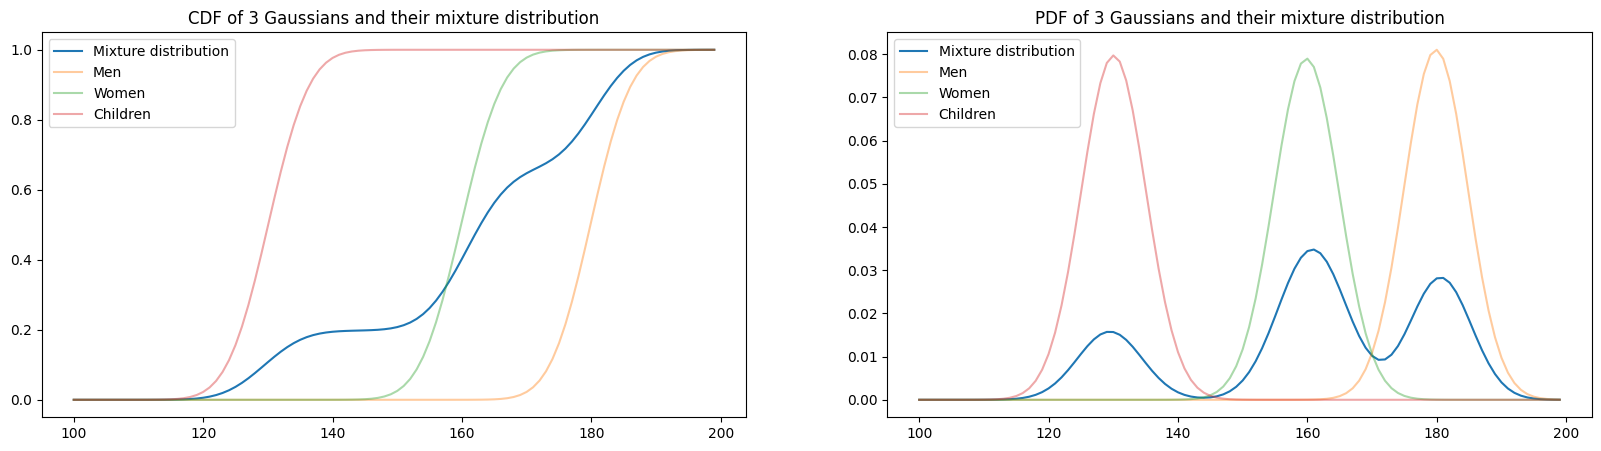

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# subplot 1: CDF
axs[0].plot(height_range, mix_norm_cdf(height_range, weights, mu, sigma), label="Mixture distribution")
axs[0].plot(height_range, norm.cdf(height_range, loc=np.mean(men), scale=np.std(men)), alpha=.4, label="Men")
axs[0].plot(height_range, norm.cdf(height_range, loc=np.mean(women), scale=np.std(women)), alpha=.4, label="Women")
axs[0].plot(height_range, norm.cdf(height_range, loc=np.mean(children), scale=np.std(children)), alpha=.4, label="Children")
axs[0].legend(loc="upper left")
axs[0].set_title("CDF of 3 Gaussians and their mixture distribution")

# subplot 2: PDF
axs[1].plot(height_range, mix_norm_pdf(height_range, weights, mu, sigma), label="Mixture distribution")
axs[1].plot(height_range, norm.pdf(height_range, loc=np.mean(men), scale=np.std(men)), alpha=.4, label="Men")
axs[1].plot(height_range, norm.pdf(height_range, loc=np.mean(women), scale=np.std(women)), alpha=.4, label="Women")
axs[1].plot(height_range, norm.pdf(height_range, loc=np.mean(children), scale=np.std(children)), alpha=.4, label="Children")
axs[1].legend(loc="upper left")
axs[1].set_title("PDF of 3 Gaussians and their mixture distribution")

# Show plot
plt.show()

In [39]:
estimated_men = np.random.normal(loc=mu[1], scale=sigma[1], size=1000)
estimated_women = np.random.normal(loc=mu[2], scale=sigma[2], size=1000)
estimated_children = np.random.normal(loc=mu[0], scale=sigma[0], size=1000)

Text(0.5, 1.0, 'PDF of original data vs. GMM estimations')

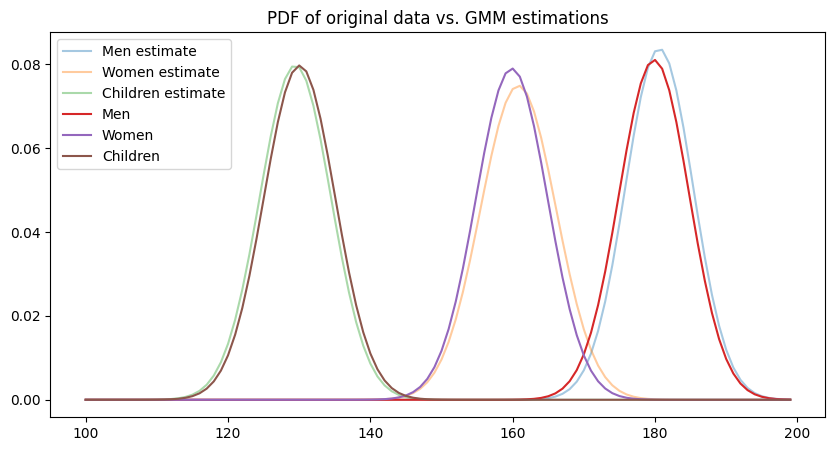

In [48]:
plt.figure(figsize=(10, 5))
height_range = range(100, 200)
plt.plot(height_range, norm.pdf(height_range, loc=mu[1], scale=sigma[1]), label="Men estimate", alpha=.4)
plt.plot(height_range, norm.pdf(height_range, loc=mu[2], scale=sigma[2]), label="Women estimate", alpha=.4)
plt.plot(height_range, norm.pdf(height_range, loc=mu[0], scale=sigma[0]), label="Children estimate", alpha=.4)

plt.plot(height_range, norm.pdf(height_range, loc=np.mean(men), scale=np.std(men)), label="Men")
plt.plot(height_range, norm.pdf(height_range, loc=np.mean(women), scale=np.std(women)),label="Women")
plt.plot(height_range, norm.pdf(height_range, loc=np.mean(children), scale=np.std(children)), label="Children")

plt.legend(loc="upper left")
plt.title("PDF of original data vs. GMM estimations")